# claudette

> Claudette is Claude's friend

In [ ]:
#| hide

from nbdev import show_doc
from fastcore.utils import *
from IPython.display import Image,display
from cachy import enable_cachy

In [ ]:
#| hide
enable_cachy()

> **NB**: If you are reading this in GitHub's readme, we recommend you instead read the much more nicely formatted [documentation format](https://claudette.answer.ai/) of this tutorial.

*Claudette* is a wrapper for Anthropic's [Python SDK](https://github.com/anthropics/anthropic-sdk-python).

The SDK works well, but it is quite low level -- it leaves the developer to do a lot of stuff manually. That's a lot of extra work and boilerplate! Claudette automates pretty much everything that can be automated, whilst providing full control. Amongst the features provided:

- A `Chat` class that creates stateful dialogs
- Support for *prefill*, which tells Claude what to use as the first few words of its response
- Convenient image support
- Simple and convenient support for Claude's new Tool Use API.

You'll need to set the `ANTHROPIC_API_KEY` environment variable to the key provided to you by Anthropic in order to use this library.

Note that this library is the first ever "literate nbdev" project. That means that the actual source code for the library is a rendered Jupyter Notebook which includes callout notes and tips, HTML tables and images, detailed explanations, and teaches *how* and *why* the code is written the way it is. Even if you've never used the Anthropic Python SDK or Claude API before, you should be able to read the source code. Click [Claudette's Source](https://claudette.answer.ai/core.html) to read it, or clone the git repo and execute the notebook yourself to see every step of the creation process in action. The tutorial below includes links to API details which will take you to relevant parts of the source. The reason this project is a new kind of literal program is because we take seriously Knuth's call to action, that we have a "*moral commitment*" to never write an "*illiterate program*" -- and so we have a commitment to making literate programming an easy and pleasant experience. (For more on this, see [this talk](https://www.youtube.com/watch?v=rX1yGxJijsI) from Hamel Husain.)

> "*Let us change our traditional attitude to the construction of programs: Instead of imagining that our main task is to instruct a **computer** what to do, let us concentrate rather on explaining to **human beings** what we want a computer to do.*" Donald E. Knuth, [Literate Programming](https://www.cs.tufts.edu/~nr/cs257/archive/literate-programming/01-knuth-lp.pdf) (1984)

## Install

```sh
pip install claudette
```

## Getting started

Anthropic's Python SDK will automatically be installed with Claudette, if you don't already have it.

In [ ]:
import os
# os.environ['ANTHROPIC_LOG'] = 'debug'

To print every HTTP request and response in full, uncomment the above line.

In [ ]:
from claudette import *

Claudette only exports the symbols that are needed to use the library, so you can use `import *` to import them. Alternatively, just use:

```python
import claudette
```

...and then add the prefix `claudette.` to any usages of the module.

Claudette provides `models`, which is a list of models currently available from the SDK.

In [ ]:
models

['claude-opus-4-5',
 'claude-sonnet-4-5',
 'claude-haiku-4-5',
 'claude-opus-4-1-20250805',
 'claude-opus-4-20250514',
 'claude-3-opus-20240229',
 'claude-sonnet-4-20250514',
 'claude-3-7-sonnet-20250219',
 'claude-3-5-sonnet-20241022',
 'claude-3-haiku-20240307']

For these examples, we'll use Sonnet 4, since it's awesome!

In [ ]:
model = models[1]
model

'claude-sonnet-4-5'

## Chat

The main interface to Claudette is the `Chat` class, which provides a stateful interface to Claude:

In [ ]:
chat = Chat(model, sp="""You are a helpful and concise assistant.""")
chat("I'm Jeremy")

Hello Jeremy! Nice to meet you. How can I help you today?

<details>

- id: `msg_01SUuWHAbhHJLDj4ZZXQRkko`
- content: `[{'citations': None, 'text': 'Hello Jeremy! Nice to meet you. How can I help you today?', 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 19, 'output_tokens': 18, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
r = chat("What's my name?")
r

Your name is Jeremy!

<details>

- id: `msg_01V2Udc8rdipXa3sKtPDsAmz`
- content: `[{'citations': None, 'text': 'Your name is Jeremy!', 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 45, 'output_tokens': 8, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
r = chat("What's my name?")
r

Your name is Jeremy! Is there something I can help you with?

<details>

- id: `msg_01Hjj5FEtToCFizRVxuGKeC8`
- content: `[{'citations': None, 'text': 'Your name is Jeremy! Is there something I can help you with?', 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 61, 'output_tokens': 17, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

As you see above, displaying the results of a call in a notebook shows just the message contents, with the other details hidden behind a collapsible section. Alternatively you can `print` the details:

In [ ]:
print(r)

Message(id='msg_01Hjj5FEtToCFizRVxuGKeC8', content=[TextBlock(citations=None, text='Your name is Jeremy! Is there something I can help you with?', type='text')], model='claude-sonnet-4-5-20250929', role='assistant', stop_reason='end_turn', stop_sequence=None, type='message', usage=In: 61; Out: 17; Cache create: 0; Cache read: 0; Total Tokens: 78; Search: 0)


Claude supports adding an extra `assistant` message at the end, which contains the *prefill* -- i.e. the text we want Claude to assume the response starts with. Let's try it out:

In [ ]:
chat("Concisely, what is the meaning of life?",
     prefill='According to Douglas Adams,')

According to Douglas Adams,  it's 42. 

More seriously: finding purpose through connections with others, personal growth, and contributing something meaningful - though the specific answer is deeply personal to each individual.

<details>

- id: `msg_01EN3RUQ7vn4KX9erCFeYeAC`
- content: `[{'citations': None, 'text': "According to Douglas Adams,  it's 42. \n\nMore seriously: finding purpose through connections with others, personal growth, and contributing something meaningful - though the specific answer is deeply personal to each individual.", 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 98, 'output_tokens': 40, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

You can add `stream=True` to stream the results as soon as they arrive (although you will only see the gradual generation if you execute the notebook yourself, of course!)

In [ ]:
for o in chat("Concisely, what book was that in?", prefill='It was in', stream=True):
    print(o, end='')

It was in "The Hitchhiker's Guide to the Galaxy" by Douglas Adams.

### Async

Alternatively, you can use `AsyncChat` (or `AsyncClient`) for the async versions, e.g:

In [ ]:
chat = AsyncChat(model)
await chat("I'm Jeremy")

Hello Jeremy! Nice to meet you. How can I help you today?

<details>

- id: `msg_01QJE9fQnqQNGEuzNPqQ6pHG`
- content: `[{'citations': None, 'text': 'Hello Jeremy! Nice to meet you. How can I help you today?', 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 10, 'output_tokens': 18, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

Remember to use `async for` when streaming in this case:

In [ ]:
async for o in await chat("Concisely, what is the meaning of life?",
                          prefill='According to Douglas Adams,', stream=True):
    print(o, end='')

According to Douglas Adams,  it's 42.

More seriously: there's no universal answer. Common perspectives include:
- **Creating meaning** through relationships, work, and experiences
- **Reducing suffering** and increasing wellbeing (yours and others')
- **Connection** - to people, nature, or something transcendent
- **Growth** - becoming who you're capable of being

The question might be less "What is the meaning?" and more "What meaning will you create?"

What resonates with you?

## Prompt caching

Claude supports [prompt caching](https://docs.anthropic.com/en/docs/build-with-claude/prompt-caching), which can significantly reduce token usage costs when working with large contexts or repetitive elements. When you use `mk_msg(msg, cache=True)`, Claudette adds the necessary cache control headers to make that message cacheable.

Prompt caching works by marking segments of your prompt for efficient reuse. When a cached segment is encountered again, Claude reads it from the cache rather than processing the full content, resulting in a 90% reduction in token costs for those segments.

Some key points about prompt caching:
- Cache writes cost 25% more than normal input tokens
- Cache reads cost 90% less than normal input tokens
- Minimum cacheable length is model-dependent (1024-2048 tokens)
- Cached segments must be completely identical to be reused
- Works well for system prompts, tool definitions, and large context blocks

For instance, here we use caching when asking about Claudette's readme file:

In [ ]:
chat = Chat(model, sp="""You are a helpful and concise assistant.""")

In [ ]:
nbtxt = Path('README.txt').read_text()
msg = f'''<README>
{nbtxt}
</README>
In brief, what is the purpose of this project based on the readme?'''
r = chat(mk_msg(msg, cache=True))
r

Claudette is a high-level wrapper for Anthropic's Python SDK that simplifies working with Claude AI. Its main purposes are to:

1. **Automate boilerplate** - Handles repetitive tasks that would otherwise require manual coding with the base SDK
2. **Provide stateful conversations** - Offers a `Chat` class for maintaining dialog context
3. **Simplify advanced features** - Makes it easier to use:
   - Tool/function calling
   - Image inputs
   - Prompt prefilling
   - Prompt caching
   - Structured data extraction

4. **Support multiple providers** - Works with Anthropic's API, AWS Bedrock, and Google Vertex

The project is also notable for being a "literate programming" example - its source code is written as an educational Jupyter Notebook that explains both how and why the code works, making it accessible even to those unfamiliar with the Claude API.

<details>

- id: `msg_011Ukbknc6uXe5DVWm6dKShY`
- content: `[{'citations': None, 'text': 'Claudette is a high-level wrapper for Anthropic\'s Python SDK that simplifies working with Claude AI. Its main purposes are to:\n\n1. **Automate boilerplate** - Handles repetitive tasks that would otherwise require manual coding with the base SDK\n2. **Provide stateful conversations** - Offers a `Chat` class for maintaining dialog context\n3. **Simplify advanced features** - Makes it easier to use:\n   - Tool/function calling\n   - Image inputs\n   - Prompt prefilling\n   - Prompt caching\n   - Structured data extraction\n\n4. **Support multiple providers** - Works with Anthropic\'s API, AWS Bedrock, and Google Vertex\n\nThe project is also notable for being a "literate programming" example - its source code is written as an educational Jupyter Notebook that explains both how and why the code works, making it accessible even to those unfamiliar with the Claude API.', 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 9288}, 'cache_creation_input_tokens': 9288, 'cache_read_input_tokens': 0, 'input_tokens': 3, 'output_tokens': 210, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

The response records the a cache has been created using these input tokens:

In [ ]:
print(r.usage)

Usage(cache_creation=CacheCreation(ephemeral_1h_input_tokens=0, ephemeral_5m_input_tokens=9288), cache_creation_input_tokens=9288, cache_read_input_tokens=0, input_tokens=3, output_tokens=210, server_tool_use=None, service_tier='standard')


We can now ask a followup question in this chat:

In [ ]:
r = chat('How does it make tool use more ergonomic?')
r

Claudette makes tool use more ergonomic in several key ways:

## 1. **Simple Function Definitions with Docments**
You just write normal Python functions with type hints and comments - Claudette automatically converts them into Claude's tool format:

```python
def sums(
    a:int,  # First thing to sum
    b:int=1 # Second thing to sum
) -> int: # The sum of the inputs
    "Adds a + b."
    return a + b
```

## 2. **Automatic Tool Execution**
When Claude requests a tool, Claudette automatically:
- Detects the tool_use response
- Calls your Python function with the parameters
- Sends the result back to Claude
- Returns the final answer

You just call `chat()` again and it handles everything behind the scenes.

## 3. **Single-Step Multi-Tool Solving with `toolloop`**
Instead of manually managing back-and-forth tool calls, `toolloop` automatically handles multiple tool invocations in one call:

```python
chat.toolloop('Calculate (604542+6458932)*2')
# Automatically calls sums(), then mults(), then returns final answer
```

## 4. **Direct Structured Output**
For single-tool results, `Client.structured()` gives you immediate output without conversation management:

```python
cli.structured("What is 604542+6458932", sums)
# Returns: [7063474]
```

This eliminates all the manual tool schema definition, response parsing, and execution logic required by the base SDK.

<details>

- id: `msg_01EGszFiTeKaXfNXJ4kSNC2g`
- content: `[{'citations': None, 'text': 'Claudette makes tool use more ergonomic in several key ways:\n\n## 1. **Simple Function Definitions with Docments**\nYou just write normal Python functions with type hints and comments - Claudette automatically converts them into Claude\'s tool format:\n\n```python\ndef sums(\n    a:int,  # First thing to sum\n    b:int=1 # Second thing to sum\n) -> int: # The sum of the inputs\n    "Adds a + b."\n    return a + b\n```\n\n## 2. **Automatic Tool Execution**\nWhen Claude requests a tool, Claudette automatically:\n- Detects the tool_use response\n- Calls your Python function with the parameters\n- Sends the result back to Claude\n- Returns the final answer\n\nYou just call `chat()` again and it handles everything behind the scenes.\n\n## 3. **Single-Step Multi-Tool Solving with `toolloop`**\nInstead of manually managing back-and-forth tool calls, `toolloop` automatically handles multiple tool invocations in one call:\n\n```python\nchat.toolloop(\'Calculate (604542+6458932)*2\')\n# Automatically calls sums(), then mults(), then returns final answer\n```\n\n## 4. **Direct Structured Output**\nFor single-tool results, `Client.structured()` gives you immediate output without conversation management:\n\n```python\ncli.structured("What is 604542+6458932", sums)\n# Returns: [7063474]\n```\n\nThis eliminates all the manual tool schema definition, response parsing, and execution logic required by the base SDK.', 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 9288, 'input_tokens': 227, 'output_tokens': 368, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

We can see that this only used ~200 regular input tokens -- the 7000+ context tokens have been read from cache.

In [ ]:
print(r.usage)

Usage(cache_creation=CacheCreation(ephemeral_1h_input_tokens=0, ephemeral_5m_input_tokens=0), cache_creation_input_tokens=0, cache_read_input_tokens=9288, input_tokens=227, output_tokens=368, server_tool_use=None, service_tier='standard')


In [ ]:
chat.use

In: 230; Out: 578; Cache create: 9288; Cache read: 9288; Total Tokens: 19384; Search: 0

## Tool use

[Tool use](https://docs.anthropic.com/claude/docs/tool-use) lets Claude use external tools.

We use [docments](https://fastcore.fast.ai/docments.html) to make defining Python functions as ergonomic as possible. Each parameter (and the return value) should have a type, and a docments comment with the description of what it is. As an example we'll write a simple function that adds numbers together, and will tell us when it's being called:

In [ ]:
def sums(
    a:int,  # First thing to sum
    b:int=1 # Second thing to sum
) -> int: # The sum of the inputs
    "Adds a + b."
    print(f"Finding the sum of {a} and {b}")
    return a + b

Sometimes Claude will try to add stuff up "in its head", so we'll use a system prompt to ask it not to.

In [ ]:
sp = "Always use tools if math ops are needed."

We'll get Claude to add up some long numbers:

In [ ]:
a,b = 604542,6458932
pr = f"What is {a}+{b}?"
pr

'What is 604542+6458932?'

To use tools, pass a list of them to `Chat`:

In [ ]:
chat = Chat(model, sp=sp, tools=[sums])

To force Claude to always answer using a tool, set `tool_choice` to that function name. When Claude needs to use a tool, it doesn't return the answer, but instead returns a `tool_use` message, which means we have to call the named tool with the provided parameters.

In [ ]:
r = chat(pr, tool_choice='sums')
r

Finding the sum of 604542 and 6458932


[ToolUseBlock(id='toolu_01L2drxj9NRcaRsZA9bUidRP', input={'a': 604542, 'b': 6458932}, name='sums', type='tool_use')]

<details>

- id: `msg_01HJgvZuxtVaV6bBpUFHsVLu`
- content: `[{'id': 'toolu_01L2drxj9NRcaRsZA9bUidRP', 'input': {'a': 604542, 'b': 6458932}, 'name': 'sums', 'type': 'tool_use'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 718, 'output_tokens': 53, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

Claudette handles all that for us -- we just call it again, and it all happens automatically:

In [ ]:
chat()

The sum of 604542 + 6458932 = **7,063,474**

<details>

- id: `msg_01AT3GKYV1bXWuDpAd3yLLYv`
- content: `[{'citations': None, 'text': 'The sum of 604542 + 6458932 = **7,063,474**', 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 710, 'output_tokens': 24, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

You can see how many tokens have been used at any time by checking the `use` property. Note that (as of May 2024) tool use in Claude uses a *lot* of tokens, since it automatically adds a large system prompt.

In [ ]:
chat.use

In: 1428; Out: 77; Cache create: 0; Cache read: 0; Total Tokens: 1505; Search: 0

We can do everything needed to use tools in a single step, by using `Chat.toolloop`. This can even call multiple tools as needed solve a problem. For example, let's define a tool to handle multiplication:

In [ ]:
def mults(
    a:int,  # First thing to multiply
    b:int=1 # Second thing to multiply
) -> int: # The product of the inputs
    "Multiplies a * b."
    print(f"Finding the product of {a} and {b}")
    return a * b

Now with a single call we can calculate `(a+b)*2` -- by passing `show_trace` we can see each response from Claude in the process:

In [ ]:
chat = Chat(model, sp=sp, tools=[sums,mults])
pr = f'Calculate ({a}+{b})*2'
pr

'Calculate (604542+6458932)*2'

In [ ]:
for o in chat.toolloop(pr): display(o)

Finding the sum of 604542 and 6458932


I'll help you calculate (604542+6458932)*2 by first adding the two numbers, then multiplying the result by 2.

<details>

- id: `msg_01WtZPpgPaBFbTrsgXMjrjr9`
- content: `[{'citations': None, 'text': "I'll help you calculate (604542+6458932)*2 by first adding the two numbers, then multiplying the result by 2.", 'type': 'text'}, {'id': 'toolu_01ASZL8TCupx5nsZqm2xoMKA', 'input': {'a': 604542, 'b': 6458932}, 'name': 'sums', 'type': 'tool_use'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 722, 'output_tokens': 104, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

```python
{ 'content': [ { 'content': '7063474',
                 'tool_use_id': 'toolu_01ASZL8TCupx5nsZqm2xoMKA',
                 'type': 'tool_result'}],
  'role': 'user'}
```

Finding the product of 7063474 and 2


[ToolUseBlock(id='toolu_01Tm19WLH85kKZ7aFmeYHafz', input={'a': 7063474, 'b': 2}, name='mults', type='tool_use')]

<details>

- id: `msg_01DR9ZrY1Mg9e3LSacX2Qp8f`
- content: `[{'id': 'toolu_01Tm19WLH85kKZ7aFmeYHafz', 'input': {'a': 7063474, 'b': 2}, 'name': 'mults', 'type': 'tool_use'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 841, 'output_tokens': 71, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

```python
{ 'content': [ { 'content': '14126948',
                 'tool_use_id': 'toolu_01Tm19WLH85kKZ7aFmeYHafz',
                 'type': 'tool_result'}],
  'role': 'user'}
```

The answer is **14,126,948**.

To break it down:
- 604542 + 6458932 = 7,063,474
- 7,063,474 × 2 = 14,126,948

<details>

- id: `msg_01Svk5xvxtWJCLw2rGteUoQV`
- content: `[{'citations': None, 'text': 'The answer is **14,126,948**.\n\nTo break it down:\n- 604542 + 6458932 = 7,063,474\n- 7,063,474 × 2 = 14,126,948', 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 927, 'output_tokens': 58, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

## Structured data

If you just want the immediate result from a single tool, use `Client.structured`.

In [ ]:
cli = Client(model)

In [ ]:
def sums(
    a:int,  # First thing to sum
    b:int=1 # Second thing to sum
) -> int: # The sum of the inputs
    "Adds a + b."
    print(f"Finding the sum of {a} and {b}")
    return a + b

In [ ]:
cli.structured("What is 604542+6458932", sums)

Finding the sum of 604542 and 6458932


[7063474]

This is particularly useful for getting back structured information, e.g:

In [ ]:
class President:
    "Information about a president of the United States"
    def __init__(self, 
                first:str, # first name
                last:str, # last name
                spouse:str, # name of spouse
                years_in_office:str, # format: "{start_year}-{end_year}"
                birthplace:str, # name of city
                birth_year:int # year of birth, `0` if unknown
        ):
        assert re.match(r'\d{4}-\d{4}', years_in_office), "Invalid format: `years_in_office`"
        store_attr()

    __repr__ = basic_repr('first, last, spouse, years_in_office, birthplace, birth_year')

In [ ]:
cli.structured("Provide key information about the 3rd President of the United States", President)

[President(first='Thomas', last='Jefferson', spouse='Martha Wayles Skelton', years_in_office='1801-1809', birthplace='Shadwell', birth_year=1743)]

## Images

Claude can handle image data as well. As everyone knows, when testing image APIs you have to use a cute puppy.

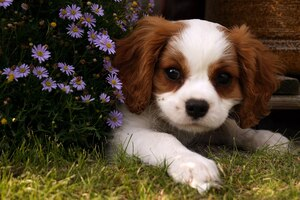

In [ ]:
fn = Path('samples/puppy.jpg')
Image(filename=fn, width=200)

We create a `Chat` object as before:

In [ ]:
chat = Chat(model)

Claudette expects images as a list of bytes, so we read in the file:

In [ ]:
img = fn.read_bytes()

Prompts to Claudette can be lists, containing text, images, or both, eg:

In [ ]:
chat([img, "In brief, what color flowers are in this image?"])

The flowers in this image are **purple**.

<details>

- id: `msg_01JPnMvi1UmuspTeQYG8RQiC`
- content: `[{'citations': None, 'text': 'The flowers in this image are **purple**.', 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 110, 'output_tokens': 12, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

The image is included as input tokens.

In [ ]:
chat.use

In: 110; Out: 12; Cache create: 0; Cache read: 0; Total Tokens: 122; Search: 0

Alternatively, Claudette supports creating a multi-stage chat with separate image and text prompts. For instance, you can pass just the image as the initial prompt (in which case Claude will make some general comments about what it sees), and then follow up with questions in additional prompts:

In [ ]:
chat = Chat(model)
chat(img)

This is an adorable photo of a Cavalier King Charles Spaniel puppy! The puppy has the breed's characteristic features:

- **Blenheim coloring** - beautiful chestnut brown and white markings
- **Long, silky ears** with feathering
- **Large, expressive dark eyes** that give them their sweet, gentle appearance
- **White blaze** down the center of the face

The puppy is posed charmingly on grass with purple flowers (possibly asters) in the background, creating a lovely garden setting. Cavalier King Charles Spaniels are known for being affectionate, gentle, and excellent companion dogs. This little one looks absolutely precious!

Is this your puppy, or are you just admiring this sweet photo?

<details>

- id: `msg_01SvmG6sdVicpzm3P8PqBQwC`
- content: `[{'citations': None, 'text': "This is an adorable photo of a Cavalier King Charles Spaniel puppy! The puppy has the breed's characteristic features:\n\n- **Blenheim coloring** - beautiful chestnut brown and white markings\n- **Long, silky ears** with feathering\n- **Large, expressive dark eyes** that give them their sweet, gentle appearance\n- **White blaze** down the center of the face\n\nThe puppy is posed charmingly on grass with purple flowers (possibly asters) in the background, creating a lovely garden setting. Cavalier King Charles Spaniels are known for being affectionate, gentle, and excellent companion dogs. This little one looks absolutely precious!\n\nIs this your puppy, or are you just admiring this sweet photo?", 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 98, 'output_tokens': 173, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
chat('What direction is the puppy facing?')

The puppy is facing **directly toward the camera** (toward the viewer). The puppy appears to be lying down with its head up, looking straight ahead at whoever is taking the photograph. This frontal view gives us a clear look at the puppy's face, including both eyes, the white blaze down the center of its face, and its adorable expression.

<details>

- id: `msg_01G9c6cJePhHroH1u27ovV7o`
- content: `[{'citations': None, 'text': "The puppy is facing **directly toward the camera** (toward the viewer). The puppy appears to be lying down with its head up, looking straight ahead at whoever is taking the photograph. This frontal view gives us a clear look at the puppy's face, including both eyes, the white blaze down the center of its face, and its adorable expression.", 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 282, 'output_tokens': 79, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
chat('What color is it?')

The puppy is **brown (chestnut) and white**. 

Specifically:
- The ears and patches around the eyes are a rich chestnut brown/reddish-brown color
- The face has white markings, including a white blaze down the center
- The visible parts of the body appear to be predominantly white

This color pattern is called "Blenheim" in Cavalier King Charles Spaniels - it's one of the most popular and recognizable color combinations for this breed.

<details>

- id: `msg_016Upuk9NJ5rfoanKi9vHD4E`
- content: `[{'citations': None, 'text': 'The puppy is **brown (chestnut) and white**. \n\nSpecifically:\n- The ears and patches around the eyes are a rich chestnut brown/reddish-brown color\n- The face has white markings, including a white blaze down the center\n- The visible parts of the body appear to be predominantly white\n\nThis color pattern is called "Blenheim" in Cavalier King Charles Spaniels - it\'s one of the most popular and recognizable color combinations for this breed.', 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 369, 'output_tokens': 115, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

Note that the image is passed in again for every input in the dialog, so that number of input tokens increases quickly with this kind of chat. (For large images, using prompt caching might be a good idea.)

In [ ]:
chat.use

In: 749; Out: 367; Cache create: 0; Cache read: 0; Total Tokens: 1116; Search: 0

## Extended Thinking

Claude >=3.7 Sonnet and Opus have enhanced reasoning capabilities through [extended thinking](https://docs.anthropic.com/en/docs/build-with-claude/extended-thinking). This feature allows Claude to think through complex problems step-by-step, making its reasoning process transparent and its final answers more reliable.

To enable extended thinking, simply specify the number of thinking tokens using the `maxthinktok` parameter when making a call to Chat. The thinking process will appear in a collapsible section in the response.

Some important notes about extended thinking:

- Only available with select models
- Automatically sets `temperature=1` when enabled (required for thinking to work)
- Cannot be used with `prefill` (these features are incompatible)
- Thinking is presented in a separate collapsible block in the response
- The thinking tokens count toward your usage but help with complex reasoning

To access models that support extended thinking, you can use `has_extended_thinking_models`.

In [ ]:
has_extended_thinking_models

{'claude-3-7-sonnet-20250219',
 'claude-opus-4-1-20250805',
 'claude-opus-4-20250514',
 'claude-opus-4-5',
 'claude-sonnet-4-20250514',
 'haiku-4-5',
 'sonnet-4-5'}

In [ ]:
chat = Chat(model)

In [ ]:
chat('Write a sentence about Python!', maxthinktok=1024)


Python is a versatile, beginner-friendly programming language known for its clean syntax and powerful applications in web development, data science, automation, and artificial intelligence.

<details>
<summary>Thinking</summary>
The user wants me to write a sentence about Python. Python could refer to either the programming language or the snake. Given the context of a general request without additional specifics, I'll assume they mean the programming language since that's a common topic. I'll write an informative and positive sentence about it.
</details>


<details>

- id: `msg_01Nf6xLjvdfweajfotWSByfQ`
- content: `[{'signature': 'EusDCkYIChgCKkCEb9//O9Ukuzu0YNXZzFpSF/0Kqi9xmlw8RTkxMf5G0DNjfYnm4ikuuiHI6c9ZreTpQvx8zZc2/JLO9LBYJbfAEgxVZO4o6S1wQTbxI1gaDIatm6hlCv32E5azAyIw4ooJQR+Mb19spCwQGVsblg455LFQWf5jjeW9cNKHP9HdhYpfonLZV8i13QRiwZGiKtICf6mGM0EezCc95fogMMuGPYFNNNpBqZ42F5jhxASf5uMEZohoUUNVnUd9Lm57CxK4O+Dn5yvLdhTOErVSuGgiZK2fUWALh1iPcZV95tC3IflGP0aJcC9DYHKkzYBCMsNLeedB+7CZpvgTPsmPW+vZUzoYepqG2kIOk8qp7P8eQF722PDODHBECo+d+D1SuZHdexumKgOmajqMUfjd11Fg8Db8HpgiPgd56lHzDKrPMTjQx/gi4+J6u8SgkPff31psE6Sp9WXorncioJlVxUKjGtH41W08nAvlSXRzFyipFXeQ7nedH6h8dsZ3OYXdLHkMzEve6mRGdSRw8zrvqqbhZpihxTqA7XjtRFoVw09Np3L4w0J/3vblI9yGx2Hbvog7cm8g3UgROllWB3N20UIk0Z55qnFXLfWVvS9TTE4zxGx8RltK1CqzSSUO2tZyilEqHTsYAQ==', 'thinking': "The user wants me to write a sentence about Python. Python could refer to either the programming language or the snake. Given the context of a general request without additional specifics, I'll assume they mean the programming language since that's a common topic. I'll write an informative and positive sentence about it.", 'type': 'thinking'}, {'citations': None, 'text': 'Python is a versatile, beginner-friendly programming language known for its clean syntax and powerful applications in web development, data science, automation, and artificial intelligence.', 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 42, 'output_tokens': 106, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

## Web Search and Server Tools

Claude supports server-side tools that run on Anthropic's infrastructure. The flagship example is the web search tool, which allows Claude to search the web for up-to-date information to answer questions.

Unlike client-side tools (where you provide functionality), server-side tools are managed by Anthropic. Claudette makes these easy to use with helper functions like `search_conf()`.

In [ ]:
chat = Chat(model, sp='Be concise in your responses.', tools=[search_conf()])
pr = 'What is the current weather in San Diego?'
r = chat(pr)
r

Based on current weather data for San Diego, CA:

**Current Conditions (December 2, 2024):**
- Partly cloudy with a high around 65°F [^1]
- Winds SW at 5 to 10 mph [^2]
- Low near 50°F with light and variable winds [^3]

The weather is pleasant with partly cloudy skies and mild temperatures typical for San Diego in early December.

[^1]: https://www.wunderground.com/weather/us/ca/san-diego
	"/ 0.00 °in Partly cloudy. High around 65F. "

[^2]: https://www.wunderground.com/weather/us/ca/san-diego
	"Winds SW at 5 to 10 mph. "

[^3]: https://www.wunderground.com/weather/us/ca/san-diego
	"Low near 50F. Winds light and variable. "

<details>

- id: `msg_01KdNccMqknT22eaDGqE453N`
- content: `[{'id': 'srvtoolu_019oGPT86A992v8CcJa7zujv', 'input': {'query': 'San Diego weather today'}, 'name': 'web_search', 'type': 'server_tool_use'}, {'content': [{'encrypted_content': 'ErUZCioIChgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDIaPZWlRVnKOp5T9yhoMOhRM1nTpnxKFUU1kIjCOMT4MHGPx3+Cot0JzjmRW+okgGsK86vx0S/7rkBdZGHJ5LFFxUTTmdYiwGFVal00quBihresZB8kXThIdLFVo3rMPWICA4mXf/nHsqCOIRxeoy3oLXCJhheyQd/Zu0sEKbnykvh/Fbyz/dV2jF3Ou5CY/9Ec5ApL96+iso3fhHNr8iqQw7qG5T6GTw8uixj9MGqkPkaOC+Z8RMvQ8ox3AZbZlQPMoDZ04XkWJ1M56pMGvyj8fbK7rKFVmuNsfFPVnY/8Rol3l6Vy+cjVlEoTUsuDyfpBNozuZETyJXmcgnSTahXuqaBhgcin1yVUJyffqOFzHJHQM1BUmZAqqEs4FbX4HM6FtZvY9Nc21uE0q3BjirKbMuKlFfYxcw5Vi5nKIOwCNZgzj38lALVOxX/D7DenCjGzA469ktTfcg2jbH5OkwWO9ThhirnCfLPRwvI+P90BhUbRRKNPPHNvF0x10KFmlpGuHxwOsIIXzJMBJoysbagJ9tVWLkaRfDRStoCRkpqX5iTgpwtfdN60Zw0Kld1CGxBdJfQs+BE2G0QGE35qcYOXV09HeNNhcT9FapQxQThEclstnDbJvRy6iA4ltU/RkFH+BdmG1ASrfAlWRXBvROi31M6dU1VwMwjlsUb57CETGeJBqdSJV6GMt42oaos1Nzq3yQRt9Iqt4z8/qFCSkX5r0LUuBi/Trqxb6Iz7+wKytYcyN+0B+055hGTlxbnKRtMQEIPioEPuUOOfhT7RGli1AZLVI/Kyb8i8u083MveDoI7x+F1bCiAbvnevtfRQh/X1lb/70D+i+kKrWWrBGI0R98fVjsKe9aevBybu7IaBc3MI4vToPXqZ7pjbp7+J07kVUS27Romh+pVkBCs+bC7P4+igBXpkizx1pHNGakbFBZH6rOyEhXgUBf/fxQXMv5RyuVFCE04XVad9zzKx3FDX1EkL42cp+wJSZqsB+SeotxbsVTkXCdaLeWeqWMOwwVIlhMOeT8wKQA+E6fP7r59fz4xoeiEefh4X6VSeh8LJpunE+vOx7ikL8JHOUW5adhtnKmkuAXpTbeN4QuXTPV2+//I4bw3bYNL5atF/Fxd77Akskj5z98UckwX9mV57HLPxDwN+X0Cz6IGCZAi/JOC0TdBR6kyCHxwHqUWaKHdHQqw73BvNpMpCAcKx/N2MaBb7pcQlzNXwJemBrgWnZpHJxpfJtztgjz2b2zHlZptkTt2pkp+t+FRHrL0Y50CP5B2AIYV9Olae7Ve8k+n5HoaVqJbi7Q9LxVVC1mpgg4WRfY94Wr1R269rlnE7zuXumv52rYoxFCz5d4EVs4Kfc6hgIhLaSrWq6sTQBHZ3ujmNZBZAH5ZFUynukOY/49qPS38VS7bQGYv98gq0fKlLA6ETI/+5lhGqkTCLvqX/RME3/L5j2WHJsN+ykvROjoZHXT5Z3KhPHEEURGl+4HFP0/cIculsnGCm5PWIex3KQn8uoJ712uwyStr/tDGMMoOfkDi3dgXJbDhA/OCmBm3Et3R/IFhFlrIfId3p8cCb4wbU2RCBY/2P0LcIuIFMr4ssbrWFiz8TwmdQAQSiTjplNG6VjagdxWjrABplLQOh+JMNcu0bbAesKtZX0bMtx4o1qhgaSwlLutuT/hgQfXJydZdwqsuEyM8BZ5fkvKOG7zFPNNVfll2Q89nYFSVCV9c36t+74ySJA83Gusx5lpZNjSLY3ichLeMoDFNOeoOpQL9BV2YLL8dI4tGXhUlQn9F2NrkhO9iRyhFpfbc7NIx1fDitC45CH7fkEuYMtp43orHYzbeWZM/ls7+jCf1iczO6W7EjBrpiO1vO+0QEP64JBP81HSwgClkBO+5OFs71MjWT1kBCESE0z0x534nMRESbjC/GLhh/RF4E7WEnsu6HTk8KgT0hRFTc0/JApmHfiwW81p5UV9zfQkDOWpTAQep9Mdq1JAuL8OhylRHJ7IMOH1EVSrBcDJ/T2UxEPnH9MNMpuCG6PianSkKwMYj2kH0oxpuF9huOfckgXBflJ/20lobcnmPCkjNUdRNTWgy0x/VtnOEHRxIoc8KnK6LNoq2p+G/VMqmaeEq99ee+fVUazQF8NyrJIdxhn7XJCaTx7BUpXnbsz1+pavI6MLYFtn0WDpFZh3LpsS+hbfuS3BuH2N/I6WDLP7fVRjQCPV0ruIIS6ngrEXHaUxhfYCtk8s+IAuAomahBAekAXil5LgO7w56Sh8YrOPjAX0hDrTEa97pJMMVkLuDFJ3paRatSwqA0Sj+vewefKtIIFaqIY+QMLgUeL9yHc6WOoIk14wX/ZkDpwbjeThKlzxWBs68nWImZKyML199RtigPBgJib7POo4LTgcjVAqxzfD+yO8P9Zy/+JdYKiaHaFVZtKMhtWwO+y5S+jeiT7Gn8ymbrkllSjr9STpOeTuTEpYpszJ2/5v3ntw3yyytKZZNKoYu7LywJjLVJD2S3GTElnbDkesJKOYxJlp5U9/Jas3TzUWnh/iPQlhJ73Myy9Y2jBWzIiBfRo5+YP33xIszt1nIWeONKQ7NIPGwbLYI0JTboKJfVzomJ5Wo1sm689/k988os6sJDZHvPren2E1mGQPVqNGlZVZqPsrppDysGLfMCmLhpmgctY/DzMTae8na95RrfW0xsPwLsSKZYwBQT5BFyECT/KB3cNlHZEJ7nnlhJqXyEr4I6FH4mlyX6qnbMSHS1E+AJOgtkY04j6FPKsfESleZT804kJvZDYFAwbgjjdzASwkfNH8mN2pERe1iB+smaXvnqiMpj+D7Tsz5V7GS55GnAvIKLo7plRt6GG0m/tNFZXzlqiE8Tf6FWEIPfG/7p+qKpPDeFEf6A6q9DcXgv5D2Ex37sy6IPU0gWOoibzRXc56NUMnKsgk8/WDaVHTf99qpmDIPACVqOMiKYex4vyJ03qkgTUc83ksU/9TItG322FbCjvON8bY+EeqnN4SvrL6t81N2aZl+cxtf9gpRHq7U7wCNCynodgGevG/dFnDnSbe0sbvxsVMa0NQYk/LWdgg3BCsFJr6P9x2jEymmF7Qfn8CUdvZP9rJke7NRhDrQlyvhVUEO10QGHxquYVG4RCCMGEWoEO/FBwSnQnyEBh5SuNH8JhfskUwgzMb9N9zNN+caN7XwpqMKx6GVZfj52vvxzuOxBwl4hAL0BT4kYeG2/CtGjo2SeFclZwKr46cdEM8JYbflArRm5PfwfFu+97HnxH0ygevyrQNKQgKN5nnEpTzhkUQALHPiEMKlj1VOpLOa5DtSxlGgy4HM6p+ufE1vFJFmG3aaOvLyUwMGpzLlijX8ZLPDBeORQSNiYTnAPuFC2VFZ2C8kJdjZheAVTUVd66nBrFkp+PcGKgE0dB3lvrei4Gd3J2RwLhHmARIKVapYqfFMutf/8Zz60JF0g4/OZMHqGH2n+QIUD8oeGWLXhpSv8/BLlbCmgNtCfchrhIbgJzGeJC4jAze1lWpCNiOB7BkDreLTCkJt+vJ8lSRyVTowwRgxy+Ih3/qZBvuWTDbvtr86pw578tiToTRVoZlaDSmmwdzceK/FKiNvQPfFmqnJqG4YUxX2tkI6W+veFXlOKT/dOmbhmLcJPv/dC31BokTY+ANbDCo9M9vonAUTPhM/DtZplgRobPolZG5FBlBLqOdxxXrHOItH5Gibzs/o5XbH3yUN/JAybV4BmD3R9RkAbfokxf1JH2Xk5Lo8R+QxUxKtgxL/AAYqaTUwkcvMroJMJndLAywIH/JZ/5VF4k+s+Wmf25WeGp+3uRNQ+aantiytdB5x5Se5E6Dd03yDn2kjYqIMoCXYYz5hjmQKjLIRyXocyPdWy2OJctNF8Uub6NfSH665/gVRf2PFaelg+QrlUsKGwz52aL61dgtswe4FeN4JM4gMguKhc2JrMPd/h/Mxb2XWQFg73DFDLVZOYdPS5tl25wGDL9U6c8nNCm1VFjdyJ558pancZc1q2Y0jFX3+rRkPwQcPN6yetGfe1eW4PP4oBN6UI0YreGDmr5vMsiUmIFb/YB36bic8c/AUfBON/gD4sKt7hLZmJ4cOzTu43OwtQ9LPB3zSoVaarDeRXhijWAcW4EsMW5ii0M+d0UCG6kXO5sf5d6zZDAv86fBmGSFbsUWfJbqqiMMFEPhDcjeYmWwOoiKYZ09qF58T6zkGAO3Q3qLTho0bHPTV9bTxI+tYQXS8EmOiF+Z0OqSE5z0tqMiyTTFbPBxisNmSBC+g21nc/JdhgD', 'page_age': '1 week ago', 'title': 'San Diego, CA Weather Forecast | AccuWeather', 'type': 'web_search_result', 'url': 'https://www.accuweather.com/en/us/san-diego/92101/weather-forecast/347628'}, {'encrypted_content': 'Er0ECioIChgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDAYfbX/PDt5k3Nb0OxoMrLEgiOFpQw4gti17IjB9klE1zV56h9I+EDQazR3RRggq+rQ9zzxB/lhrahHx/N7hxt788ukIPuq8B8K4FGoqwAPPkAN/aV1G7HMlzz0Ua6dWpHX7UDXqK0nXCwSoaf6skbLLlYjaHyc/NrPAUcpWKb0fSxw7/qAlQ819spHPJaDd12gc4eB+mvRJvq3JHlL/IYLqMnmyVP3+pACx73dqcvbe934WDGGfmDUuCaTSE6qrgpDs4pY9X7qtVHmkiKCGcocr4hRx+byox101CXdYmEIqS/G+unorXIXk1QjrS3IlkdZhyaUObJyFAI2ipoO0c8XJeyErdaZuFkukzneIbUnwV14ZJmqzcispeaN5PnajC3Ii1YHj1gjPFWl6h7fV7fjwQg3BRaE7xfOAsd6VVo9r9OQOXQL2XsHSthPG5HHV/NouRU6IHi+02aF752fn58ZuaPV3QrmgdQwjZgGq7+mapEEUb5tnlSqiFXnDQu4bgf5T61tooHXaixOx94ncI0JiuIuoAO44ThnZAw8O/rmOQne1MfxqzhgIKkfqSxcLl65qHyj+huSTy2bkLRXhE9Uky0lOnSg5Hucua0gqRQOF+UpS36HGMJwzyhAR9o/BRAWt5Zvf/ci9RmPcCGd6ponesifuuK2ZV6gI2sdd4EuOAzxdBQK6+EAm8hYu6tO/GAM=', 'page_age': '1 week ago', 'title': 'San Diego weather forecast – NBC 7 San Diego', 'type': 'web_search_result', 'url': 'https://www.nbcsandiego.com/weather/'}, {'encrypted_content': 'EpoHCioIChgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDDSG9vvtGO/+PQ7F5hoMuLDibaBbb5J+91+9IjDYaOoXvxS18xWIMS6GoaZSrBmAu39bff4pz80lig0UbPY3K8qedY2FanfADNCx22MqnQaB36Z/Pp+D22kVLNoPIwJO66liWRKFSYoqDlPdBcmwyBQNuDkMEQ4y7ntXg2Qhd99Sj+wv8ubJgnAFW6jgfCbqBXvccE5WCPMeTAhEW8ejoMEdt2kk5u8NWGYtsDHJ/hbV4uVFgyBVPedBgqcw+lCbid93PlzHcS9SRW8UDo3bfE22vIJqUNrccX+Q/dUs15VWfs6latIPJJzKSMOxlL37yX36bvP5wq5PUi+g2V/dQLNo1VBat/P8eST4eC27Xne82kS6rIaKnLuSbW+1PMFOfmdu+NP7fYhvfWpI8EQ4LddiJiO3djmrgsrub2xcTso9w8gQPk74w6nvFKksDVNOgUfiWb49qIWws+NJO9rMNyqfbOh8BW3p4ER+kThWEFEeNzrG7tdBJSGZXcbH1ddlqBQ3kqnhjO/y/pm8qu5EI2lbpkglL8dlFaWZCHsj3y65B/mvEb6w/PNrJhd1YCyBIxTfTzacdNjLV+blNYi3ZsgX+bSe4aWBki5x/vBqS1S9RXf3DI+XNczfuw9hYU7aXX03bA3dusOYy1fejdYCIbGjCgox/uDJpzDYbF1pXQvYUAB2IkK4oJypCE+z3oSVjP3t2j8KL0/CVLlhQwlmJoIrdS04lfEFdcKKzwwTeKHrjEfEpIjCmASSKUpMQoB1oBpkZN0daYPBIBIAX+cUsnccE8wQpLuJRgns4Qj3fKKP+KpBSAKXPywChnhH3+T3ke1aZU1kjdbmnr6y7rcYZXGrYLOmlOG4AKotjpRCKTQYp4H+x/KRMbSVtfSKHRBVUye1WmX/ISybNH/j7OhT+RXaXGosgjiwJ1Sos+1Qixl4C1VMyZ1evTtbKCLIXc9RmvsyXusRy7YuyArhSMvV3dUBmkBAdTT32fFBL5SiCeDWQWzTDhSBRvPM2XZoZ74jEEhcPHsJXKPlEtb1riE4g0RNl6nM0ak2sFFyTvXdBX38IjC4WlyPpmVMgODCSi0sghrrv3TwgmxktOzB8FqFWYUMmtcEP+/KNevBE+BwLOGlE4i6H7HBBIcEjh7YS20c6XbWBO86OewPLWUCYBgD', 'page_age': None, 'title': 'San Diego, CA Hourly Weather Forecast | Weather Underground', 'type': 'web_search_result', 'url': 'https://www.wunderground.com/hourly/us/ca/san-diego'}, {'encrypted_content': 'EsoCCioIChgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDOD8jpVVI1Y8wAFbIRoMu2pPyJx27/aZmt4aIjCnjE5zS5/NSsTSpTt6cTwvG/5o+qL1WUvzuApL0MgJeZCKhbG4CxGa/BMth4eE0r8qzQE6h43bsOFsRf2SZJV/9nSAPqz8+CGYNICQU3KajCi1PzZAT82XGAZPq38I1Yi2RGHukOjHPZcXjQaGOSVPIIsc8g5Le+yCwkY5yKTE7H0ddgvRqRyG79DQMOczg6Rof0fKiDiILn1+IDueeenVSDw7OBbTsFRY9vn9bcYNBkDOHgE9UZ5j7w5pc/+im1XaIANgVKJSEVLgQEHMQDYC88PWukL4anr5qz4A74T58QfuFAAncUWaNj9KutvxY3bjZpvgy7FzXoeCjm1mD9ZJGAM=', 'page_age': '2 days ago', 'title': 'San Diego, CA', 'type': 'web_search_result', 'url': 'https://www.weather.gov/sgx/'}, {'encrypted_content': 'EuUJCioIChgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDC0hIrbCQcBpkxK43BoMmDAhxJ5feHCUOMmbIjBBcNiSEQLizvwjh3ifIbvx4eQXWHU4AfycV39C6L6LEh67wvlLWLWGwE314HPpXFAq6AgOXA/Qhc8BzJc7Pjj3K7QsFXqiML2rITjQkKXBYz9yhjVXB9pu/tv6TCbzzyYJDzcyJUgvm9nwjBRw8KPZaps8kJuWQbOIzOXlDwHq3NqeTKhYI1GjLU+G3jBnFYj66ksa9qoeSpLN/1e9gaqXPBRgfYGft7BPtTjPJ2oFL1UZP2ThjRCkrzyTiLgUrrLNXD7++6vb3VJAeIHeXTgNenH05yIEFQ6g7n28Twx1w8eI+8D5JsHZSxX9Fx6r69UCB5EITOOiikoKKsof7BKZ8yoIoj9NkYEziWn6McakHYRXDwD21CC+QUJlMQ+BFbGJLPf9HrKCbMCdJllx71xxsSqjGLPSgFnmEsWA9pGPXzcJPUo+0Lk14ixj+a0Eq3f6GtK7EgE+ESMGC6Jx+xtI8KnVlyqvlngHiUbE3d7fbNVDsOJXvCtOkOMtp3xD0/p7D9nHXAme98lZuZOF9TspdSGplPtYuy3G8XWp3Y0S6yn9fccgZQ9KwuL03IAvvKaZm2211lZudV38a8hP8Nrbw/hsnSXrjvgc+ukGaVTE/Kmi/c90DulAhfxYt7ROGbNnQxRIvKirjI0rxbIVVi35R1qtNIoT1hsEhGzFD4FTCUCoN/oLvYHUFxTeleA1+JIH/iFiWrrUqIYD3MWmYsmtmUDyGZNPFfMQ9T+TV3/HDAQKbwpmV+GRcykgoh2zfdT338BLvyJX18QGbGfHCkXjddVTqpHOtZPnDWjUkU55Ij1NSZ6S/VOZpBMgOohMNn4w3iJ6xE/AwNNmnLHV3RH/6/INC7rUqU3V406lIw6X0DALSy3Ee7oi6o/8HjSP1hFG+wbRyLGhouZ3WCBvZaN80Xx2cR42VEAMofQ/oTlEVpe6ZL1+IS+U9bL32ZFDkjL5Z2mC0Gzj42MhF1s6dK5WXh72uNAtHeUHCnvpMtKyp07f702cJGsP89wFJCzHLtrKlW25Q2v3+Id1Z8ADQ0mY12pXZrGhsCztOOqzFJ0a7Ig0hHtnBmkkk3M1hGJsK4xqLxXz7qgUD3t9yyZGVaG1BM35MQlRBpbYAgPb431OU2TrhreSnG2pbZpU2qOODd6HFHkJKq6rg9EyhHYitN9Xu0l8EC/VCHxAOEb1f/3dmONGk4WmveKpVDRTgp1WJQB8hneRzu0xWDaplUDbRabRJT46kXP8XFxLWGULvoYoC/GU3eoATxJ0YQMzPtXDdOOyJXdGNWUAsTbleZjU6Hh7beWq7hVPIF87is/O+q5Fo8+h8STJQdBLWHXbl3Mw8gy3zrGlcU3VAGeu9SgSsXkMfQmQESSP4Q0ah1IZq42WHtABFpYoJ/8nDILVr32Ragz9Hrxesy/NuYlRMYZI9ealkzRR8mWKYQG06dOr1A9OIIg8vUJnIomMPEhEE8UDu1w865PnOmJlwEw52TDWSZs8QZQaac67zEwAaJFzVJIfQWhdoOSpKQ6cGdKjVMW/tCorBg3vAT19kGJCLSD9qYaLvWhFIsWUsiRHMQ8YAw==', 'page_age': None, 'title': 'San Diego, CA Weather Forecast | KGTV | kgtv.com', 'type': 'web_search_result', 'url': 'https://www.10news.com/weather'}, {'encrypted_content': 'EuEMCioIChgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDJZVlkYXAtPoKqP5BBoMvo8C4dG5eOib4s2ZIjDyK0LYWdfO77cOoo206v0ldtUkcrGgoU1EId9o8cSwBJNpEfw82vFeru9k7jhrYKYq5Asv+or2/EjZfjhE6one2whHpvvmaG7Qhvb5HftUkp3ImlZR6kdN6+9B4cdG450+OKZEKoT9k5pIhJnCbqFEv6XMlLrXBKadcPROTlzIjvC5YWST5hHsRBcDKspFJOV3M65sLTMwAjG99yiXbBW8rvHQIU3AH3JQDJT/N5UIWGWRzUEzmwJZZEjaYwmDlzfM3VN6Xuz50HUajdgysOJswGHRIsPTcpJEBVjcYx89PfKeWf23EhWP15EO+Amx++1+Kh4TEcEp7onbQ7AH7JM8O2cfhkwy+pp0/BD/caFn+q3MWHAzObiCyv28nk/6LNlVh+VzHECqtRhLdomeqgDoBqn+afRxKcUML0H26qvy/ryV6MaqCoVOJKh4iTFgueuE6SHv1Y1f0ZGgYrKPtMtBZAcrZqhMpzdFLoeX22XLNeOoib8OH7Z+R7t41o9YVd5MYJ9BEp8maPzgLRok0jMr9ZR2ZIqtFMa5XoZeoIYFJni1LlAK9TgI7kftB3n4aYmsrqP8KKU7IiOspuJh3m0BU3/N1f3/fNmv0a9eHpweAms1KX45Xnq5Dq3qSGucFmR4YIr1+PISJzX43eJnBdXtukA9QlSzn5veTjBIlb4vcJIahd3WkiGufabhJrHEVTAQJ6CgcXTsyJpazQXpppjauoJXP/3nkE4b8b/7AOgrZTKwRW8haoJ9+/w0Y8xJf0akW5tpMd66xGFYK2yJOM//yKgLEZ+7zD1V9/RsQrAJVaNP8qI0KR6Cj6reVxYBC/C3NlS/YNQ7U6277CMI2H/CZur232pSQhcPUgKFCEyEcq4UEblPkmj2uuGWLO3ZbziKDivMfSufCGHfbNHdaVH7L+jIS1KaNvN+KRxFGIUbIAGPQJ1Ax84KeklU2+Aa28P1e5pKkvxJSkxg7YVlB11WKsCAG5E1Iff2ZehoEuTso1j13GS7cN0Ly/ePsjKgNfcjKt2T1twsO3aTr/ODvyHOK1+bfJ+ioYC7ZKyVg7MCm7W2nTVClg1DOMOsw42NveOguZs9oGaylhdj0OEpvJjV+exZOciJwhCsZMq1XLa8rNqV63uvHNU/fpolyC7cIsn5HinLkQZaIVbbu2zdWIqNgQHy3fmQ5VdrG7yWTwJNnCxaZejGjj3dKNVrBnV9DrR6oWajWihaJ021+RYls9eBy2rjmot44iunyMuogjfCH+L1Y3h+eg93P8n1VOG8Q0V3nAIQZJ5ovSATitwxtp10iA4FRfeitbC8Ii7+csiM5dB2IyFXHOBaorFIupcZXK+oW5qvbqjBYL9vQMLFXCDjLE0oAqtdDYieRQEC7pJ1JP9+WjOLAd/OBrexqHQsnM4Q2qmlJ+vVZ+G5IZ6FIKlZOhBVp4M7iYsWqVgWn72jU2Xy1l8VuR0DScHUsnR7qf8PWxTPRI762lKIeCjdN+fTBbIfqEWVUO4YaS5zVLnb/urFgPnLsyVS79myJzWzd5ZVoYQjkk/6RlsX+11nxTSDfo1REl6bDqa1SywCFRyvoI7eB83sA6hPckFfitgzxnvKCsuXt9/tqPUwLEbDWvV5SONgeRM54JGw9eCJNbpWXs5C/Z0fBpTI2di9i06dERLi6fKhYknea9dl9jITan/3vrx2hasrdDRDhpkKJk2IAA419KxRkFZNZ/zhDoq2Y6bd18q1IgeAa55VkfZx7EDhEReNssG4Ym2iDqkShlUWVrNwvRdEFlOR7FUftXDXST++BVW81wwOxOQy6BacJOZYMgJ+4Ar6VYSGEZuy+Ly5og5TpVq9Lc3ksEgLgVlLTdJKLGOXA0hu+xVquj2ALYIyUwVGDkRKFW0pX6tP4HZHpxfrpbH9Z+xYG5QeKa/YZ06BrDISqysBQjpmYQ3yMUAjUo+oopXUZNbm2/ZNFCte9jOQMC9U6jaOndg1CkSd9GxohVkURZlQxPAKCxS5n0BSyf7L5un+KO9/7JyfM8xiol7h5ImJteRocnKBPtuJopUJd0udlXp0WoWOj5rdAmQrySWGX6GO0BgD', 'page_age': None, 'title': 'San Diego, CA 10-Day Weather Forecast | Weather Underground', 'type': 'web_search_result', 'url': 'https://www.wunderground.com/forecast/us/ca/san-diego'}, {'encrypted_content': 'Ep0JCioIChgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDO5W5ygwOmiK+ln0IhoMZO8RDxGhzMYCbWQUIjAMneqIyc8oZ9Tk3KdwL9BtxQ8s2Tzu4HnfmkTwCS8OEd8YgbfGnigK6d2kPSTDmEYqoAhe2EWI+kZdKEpmqWpnmccp6sNgTY6bEZAq0Lr60qt3ZPqCo3pF5gjn4vr5hZ9WsofWhob2S+2Ice6L422AUA2WI7qx5MlgZfw1yYu+RRiTjGSov8+03G3qLT+zqzkecU8kGSaCRHO+xaEitqEVfTJ9OZw+rSLBC7KvS4TmX+IeNqiZFPwiautvgbvuG5l6lCtwfpxr38osXXZpssLytnU00HkVhKHcKjyI12rrk5S8hwuLUGNFjE63Ww0ommFKrDeVmGkXKCe6Z6Kc7/sp2vdw2mFmVkUp4zoXz35vMzOO2mwofsDPDenY/ZSKzYrGZ1uYn89KlH1CyeOdLfU4gY2TS8w+I36W9JYjXHKIPMNHIL2KmPISgnanCnKNTHR5PXKlw2tI3tMXhkJsWQNsmnHa8niebAEKBMoZk1phlmajiAhAaas0yFRV1g6X2hhyRL2zxZv/Om3GsomGNrNGaRnMOP/OWLM6OV+F0CmmPzgA2Njz92Vq6f927uDTJE/iGyR0OlpZBAqgiP97/3MCrbl1c3WscAGZUGhqTAyHWt7jOmpDXyHnv+ZRQSDOOw1kujrnQiubNoXlMPoyFFiL+r0EZZRmRrTfQahkC3iFHcBdlJXv+KqKYB5kEwM/78Ua6sB4jrAkylOeH54x9gVkMhsh0poetXr7tGfEu5Hcw3UvJgskyhIqGUjPE4YpuuW9vgQp7rfhKStSBcK+Pjuv1DKc3QGhED7yfnePhwhteDQZzhQprLEazq3Gy20KwRnUwjY+kElIiKCyiPP2ge8+riGRYMINdCSkzlMfIzIIhoaDoE4AKP5Sx0J9zpu2CJ/+FFBsycRaWp3yxUKWFWo37HOI600+ITzBsEQDkaJv6wk8OyyFFoMWSOTnTRs25n2NT0d5WeJtnKT5a0M8HTvF7Ivywph3q7x1VwZ3Z/5ltajLWk25j1T0vpAOqLn1KjzBWjexePgjK3+fbytP0XhNmCBGynvCFhTKze9wybeQ+FMCp59IGMRo6JtHs900whelhYd2jrNUSGLHerCCZJuwn+JlVpsYYHRrl3dsqAlHWPE7XAyiCe8IhLpR5rhhJQ3fUaCheZ24PmdwP31QCEIYevGv3oSFwJQYV3YsB0cIIsshCgRBiIpYI3UtTM9Sd3H26/5QFFH++4mMiZpsNsZuXDSs4gHkrEsFCpqOx7jHS49d1rv2u0xlA+BIVY/GzsMjVPYW6vet63u9y+l/kH5s62uWfqz9OAxsqnQEpP2rdP41Walq7GVkkL58gVugWj46id/vgTRFh0CV8ZyuTNeltGIv4nDrHKZx3j0JIzSZBzppxtSzGvabgVDTxBnWhlJSThdIFuyka9BKa/qAPPS6sAYnt0hUG1BtfJHywTB5fa9/CiNEzWtoTi+d4QMtlh204zMYAw==', 'page_age': 'August 30, 2021', 'title': 'San Diego 7-Day Weather Forecast | FOX 5 San Diego', 'type': 'web_search_result', 'url': 'https://fox5sandiego.com/weather/forecast/'}, {'encrypted_content': 'EssBCioIChgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDGAnvVIBF2l70kNUeRoM0QAITt2Fn4zHJdy3IjCwTSlse7se6C2m3S9p9mIufPhymsxYFFInY++cOwiV38vAN8QiFMFMt6jzPhgpmDYqT4yGaWjsIpJMVdNjbhbHk3qwVhF2gLUqaMZBCOvRxzZ493C6vk5e32FKEixDBWYhF7NMR49zSyx1x8OVnZ0rQtqqhtqB8LeppAXZCkxxK2oYAw==', 'page_age': '3 weeks ago', 'title': 'San Diego, CA Weather Forecast, Conditions, and Maps – Yahoo Weather', 'type': 'web_search_result', 'url': 'https://weather.yahoo.com/us/ca/san-diego'}, {'encrypted_content': 'EvYECioIChgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDPPnOH/ulHWP+rgF7BoMs9Hc3lGuR9cVDiYuIjBeYWwRONSbpnPB37BNi5877X4EARxJGlDkUwO4MtFJSaIToIogZMaomBmd+Gd7Z3Yq+QPPu0tAaZcjSh9YoFXfls/nyj/2XK7k43BKC6xqffusQUFQoq9CCRlmNQLXmVg9H2Fvbr/ELvqAoJwjmmQmfAumG2FGdp0YZSKyBleIMI/CXleLeGWQKZo+vPx3XQSISN2LsC2WWMwza1ITNd3QTXYP5UX2bBK0HoMQAVd3AZyasUpTbhndclK9+psj1H37pc737cCcsIF8sGmSebEIYirjoGbHf/iFZIs/KdXLq0+WqEtVsZkb33weeO8nJc8SJSTfPufKGpBn0/CfszrH8EAzCwdEi7CgYIeuBizAP8bWN3I4LO/BVCk6pMlzAZuIykLTPnXpmQK+MsJTLLv3SXLX+rB3zxXzyUYgM1jsQgXPr0kqrzHKWelggBv85Yp91+JiKM7Rxi1s4qVj6j9DThErpV8BajajiQVQoAju+9b2/wqw8OatZNI3iPqqlrHCyskln8D8Xps2YsVrZfGvXVgCno/w5AfpJPv1gOPRCnHH2X451UXomvI2TVaFROIoOwFwr8RxTUqfOPMduIsYSo4TVatwxhXD27he70gaRl1oNA23jYSL+378sVLhlZxguSjbPA1rVFP14mRDd+2PRbZqetPMa8Go8yu42hRPYauIBkJptlAcgFowOYZTBMXOBvCVkXgF0f3LP8CurxPWDeaQjSLk0ttswRVIGAM=', 'page_age': None, 'title': 'San Diego, CA Weather Conditions | Weather Underground', 'type': 'web_search_result', 'url': 'https://www.wunderground.com/weather/us/ca/san-diego'}, {'encrypted_content': 'EtQVCioIChgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDMq39K+ujdxRHanGXRoMpGQVRNNRIBnDyM+sIjD4XLO/4WL/XgCi9s+Mn7NiemCMzJuvDnn+nZ4vLvXKvFV/8cvUhJWiHb7OcydfCTQq1xQ47K+tvFafEiTtJyXvreiimI6Bs264yzFs7kN8dN/B1gDhTbrB9pikhs9iqPApicbvIRb8OJHwYtuO41AGPO4lPM4X+Wf1jv06Q2B3HzaD6X9lVnXe4saHSabrBM+9ecKwvvw1B+wsLwKG0OwXgefSilwGlymkOpO2u+7uak9llvCP6E1jUwk5ftxYbVIQxKW3Astm2HT9tMOeZKOSpXiYu3MeRuYo7YR3mUCHClGhD5e3B0rzmmHqq+ZkSnf6t2b9zKSOSgQxhyog/3gNYjZk/mS9ZBypjwR4YnjK9fvuBehcF+IRiqljR1ENQuDK8j+DxDsoyw/9CePP5Ji5ZTVQ3IQ37Amo6Yoou7Fhfl4AhpkEgiMWqFSilEn/RJhzN+KrczOW47Z6JHXE0NmIFt2F0OrpMTW0wKaUEE6EdpXLzWYuaZcbJ6bV45d4qVbVbSDO9po8irXz+rcQOnxg3/RWc8S4GIT08lg83UUVaKhSB1bceqmqjlCmPcG4qt8S2KsFvM8nm/H+VTeOV2qLw49DpHthxTgi8zjLpopkYTEH3OV2oGfvg0LFIwc6XqPWsqHsMW8fVuKu1EGCZTOfTdJ+tmgYG7guJYl9m+F1Iq4hY7I4jWvoV3s6TvYQgQc+Y9MXF63PCrM8rI+pPa+Wnxa37Ii+9qiTG6LPHNfE57R2QSsVBrkJ0ig+b0df2Obc0VLQBe9iyozx8h7hnrqiiaThvvaz2NfySOdTQ+GTPwpPtBu1k9/28A/AOL59zNuRlCfbb/Ttj1nlpZ5ynb2XVcmYwISyAg4HaF6OKsGS1IpNF+TsYosGqIs3UnRAU6HxpLG6qFbTwo+S8qR9ScXCl2zDcSbVa0ykxplR9+CWYQkGnEGBcvT7+u4UcB5x7OsJH5qds3azWga/lS1MgWog6guPIiwyKs0s+nGJv8MCGPARfarJmMCOjrf8yr5JW34mgiCXA87L3L8xewEB8CedaKnyQw4gAaHmyFUchQas5Sqp66dGup4NkBiggXcRZ+S8asTMKuSwKw097xh7LmK6oMUIYhG2Fw2GlrAotBe18541seVEAs9fFtUGP7NfXa6/PDclG09x19JrVdDmR41ewZZnAay1Ru9+PxJnc7s8bH2yy7zkCVIaANyo4jls6vgNSlOgtLax84cmXjXgW4HfgjnlSwDJ5EUt6xG7j3NG7syxJtHPJbfQxLUOZgz1Vtc9w2qFy+6JWJG615k3ylmn7YN5OKEWntTFyH9IFg4ZNmy4IAaqAKNRI5oDPtMPZh7OtNS15NsrgyNB1MKJ/urZiXTvgmIBGZ1sOtKCEm52k9VZf5rHL0ze69DfoGn+bsvoUivHx7+J2xtozYHuitnaFS1Aoze7+PfHBXu1kli5fx7UaJIBAEf5WHE9621AAi92gT3EpWDQjiSlhIs0rdajXTAspS6QMz95XkfU8JLVl4rCuXFfBGTPHID6vXfqFkn4EHVeZODGFqWuhH5aAVDyMmWJhE8czKyq4I86rGWpzOSwbgfZDNucm/KBDKU9jX/Lp7zf1VTuYeutvCuv/tUtRsN+dv+akgH+IqHVLERQOu9CoSH+fMGWRGImdqtWxB581Aj+cT9pgIUXqh8OPsInH576EWvkvRfbtitQBJzl85uDynpd4TdM/63l9TWNz45m+m2yjtPgCQIUNcuq905V80auMgwgJ1HwojzhopflQcphg4FUwRw3I2RLIs0iRRLeknO+ITMvfskhTE278yc02BTkBj/wgjPVuS1w7wFazdNwo9u28/ecPeNq4mCWfbvoR5wkuuaj4bUlJwyCYz1m2qGu4LZiZuQGPizQNXOetsM10HM7i7negFBzWD0NSwQG2+7X1kDe2Au7NB5/zIRpK/WFthBOOYDXHWiiyQPaLjBOUyqNyQhDdXrSnE0A/M3JyL3iPXwtAF1zpXWKtKSBjdcfgshEKfCB0ou55OfRVRFGVeZJ8toAoGUrAVO6QxwCHEXuPcuESiifcyV3ihJARXxPyguqxWOV4KXkILENjgd4dbHkWUFAK/1xRkycszcMeOVPGBIoUBjeXei1lP0vc1gUFhRyyKAQGHVL5SZeMuF8O+1FCat68pAjposnwUvNQQI/f4VHQiR1fTBuoALy7ZBZ8AT6+VrZnhsTi7PTXWDWVdUiKkX+w/qn4jLhB1hA8g9Wo9i1Btp89Stci5zq4U9jr9WIBPFYzP4/Hyr2JUAqahEpqKlnvll9AcAUxHrZtNN5VYrvvLhhhYusY553y1nYyOMUGQjI62ksBYdn5ZY3ykGFzg3dKqEsD+fBA5U+iI9Yl0Xxkiw+TVJIw/LMXc5YcgNduVr3KPonuq5t3Kbu3Wtzn5ak8OSmxf/OQj5JIr8X+5c8qtiniRTub8+D+xSaTl2raBJ2OOLjq3VsbW4U1q6l6StpgGmkDyDps4CHs9bG1bho6wqDweN42iBdhbvCEF3wIOP3sZVYANR+S+zev3hb+xx+5wJ9CZlw+f39djK5h9+oz94kBo+2XLa+7PiAbqX11ZuVpfQQ/D06eBuxH70DUgZy121So9mGbHbhi7iJAirKROZt+MQwIK1jzGHZ7MHxC0/Qqqxkw+FQtKpwVDNZttdWI4N04ggcmQf/keXltWobTgH0Yjb1wlKdknwQPsn3MD8BM5WKcdcaUccFwbh2H5+5FvJTMeLy7JeGFxjMVpZqe0X4qA0K9oK5EtDHfvVXwaLrMESM+HZS2s1pZnlb3DEDvb1jwDN6OE75F8zw27HGLkjGavLWMG2cqkkVeGb0kXYb+L8+O+PX2eDRqUXn78kLnhRgBWLuoiI0ftpGPvWL0ka5k1HbGe77s+QcaCIEJQ3PIWR2M6rRRb5JlcpSslm0CVvPadENTpx/9BcLrFP8LK3IN/Ppe8RTXdQ+qUf3I++hns7f2deamFOLPjsxkIU0sVX6MX0y3ScF6OnHlCsnpBZ3FHFiJgzybXlxbMyzeo2N8sAssI8Cm9k0oiCKIer4ja/O2SmrzfeyiEErRuzFmRIS9Su+5sY9SZ3SDdR/DbRcVoVltqjdaqaexLaEXgXL5TcFrwSz2t+BXfjvR3utaKx9pZvgydJRZbK8hqL6dZ30LteksfX4IxCcAeT/kUqRt3EdhJXFLcZ472lk4ahxBrYzEhQ+fnE1jW+ByfsTtYPWcTONj4om7FVHzc/IhH4LICHhQ1/BMDkTB/2tWIEDFUHvQlwX9mF6qjEyAm/rtJ1dfEhVJGAgqOy8q4CWVDfPKXK2nnzM78dQrxshG0MXWwcZBdjqPkUeqW4ff5GveI7B9ZYmHWgvnGWanZ6rz/Wt1d/zMvlNZWDiDldoLvPJ1uSBlzsCPXDdwnRtIxk3K4Mkmd3n4twcMViG+W6Wb5j5FeCLPEMgJAb96TZjJFOLk6dJ+aTqNOI0tXGyxtWrkCus8gxiJZTB9X1QLe8QLO6vDUvyQa1sKPxhtzYXUbXhLfkDh1ZY0MxKPyhEvE7u72IYzqhBWsRqLsXEUdFX4OCgD883HC7y0zu8g8PN7084QlL/GAM=', 'page_age': None, 'title': 'San Diego, CA Hourly Weather | AccuWeather', 'type': 'web_search_result', 'url': 'https://www.accuweather.com/en/us/san-diego/92101/hourly-weather-forecast/347628'}], 'tool_use_id': 'srvtoolu_019oGPT86A992v8CcJa7zujv', 'type': 'web_search_tool_result'}, {'citations': None, 'text': 'Based on current weather data for San Diego, CA:\n\n**Current Conditions (December 2, 2024):**\n- ', 'type': 'text'}, {'citations': [{'cited_text': '/ 0.00 °in Partly cloudy. High around 65F. ', 'encrypted_index': 'EpEBCioIChgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDLPtWgSYdxIIR10PCBoMfJ9qEfU8tOelov+oIjBGRS/tFBx/3DU9RB1aW2A54lOSjHFkHOA6J7pnOkeOwAlH69u098JOANSO7vRjnPcqFU6Vt6eBMO2QtzBEXrcCE1XNSyHYmxgE', 'title': 'San Diego, CA Weather Conditions | Weather Underground', 'type': 'web_search_result_location', 'url': 'https://www.wunderground.com/weather/us/ca/san-diego'}], 'text': 'Partly cloudy with a high around 65°F', 'type': 'text'}, {'citations': None, 'text': '\n- ', 'type': 'text'}, {'citations': [{'cited_text': 'Winds SW at 5 to 10 mph. ', 'encrypted_index': 'Eo8BCioIChgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDCUtkjMhKD0IRuCUXBoMMWgHINdZM1psHgCGIjA17ERjerJwiNAx8enMNZjXbOC3pvH2eLxiOGN/zclGKZSPMZDMV+Xw7W6GEqv2WngqE6SLUP8QTnNf9A41fgAGzxomRw4YBA==', 'title': 'San Diego, CA Weather Conditions | Weather Underground', 'type': 'web_search_result_location', 'url': 'https://www.wunderground.com/weather/us/ca/san-diego'}], 'text': 'Winds SW at 5 to 10 mph', 'type': 'text'}, {'citations': None, 'text': '\n- ', 'type': 'text'}, {'citations': [{'cited_text': 'Low near 50F. Winds light and variable. ', 'encrypted_index': 'EpEBCioIChgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDGkuEYWvDjhQUxXOiBoMo9v/ksePo67R8hZJIjBTg3Wa3XZDZPXbNsMlgDjt0CHHRs2Upx5Iqyf+U1b+dj9v9IKKKtiMpXfInKvasAEqFWcOBi+yxAcqq0+Vdo0x+cxkLqZS1hgE', 'title': 'San Diego, CA Weather Conditions | Weather Underground', 'type': 'web_search_result_location', 'url': 'https://www.wunderground.com/weather/us/ca/san-diego'}], 'text': 'Low near 50°F with light and variable winds', 'type': 'text'}, {'citations': None, 'text': '\n\nThe weather is pleasant with partly cloudy skies and mild temperatures typical for San Diego in early December.', 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 10381, 'output_tokens': 207, 'server_tool_use': {'web_search_requests': 1}, 'service_tier': 'standard'}`

</details>

The `search_conf()` function creates the necessary configuration for the web search tool. You can customize it with several parameters:

```python
search_conf(
    max_uses=None,               # Maximum number of searches Claude can perform
    allowed_domains=None,        # List of domains to search within (e.g., ['wikipedia.org'])
    blocked_domains=None,        # List of domains to exclude (e.g., ['twitter.com'])
    user_location=None           # Location context for search
)
```

When Claude uses the web search tool, the response includes citations linking to the source information. Claudette automatically formats these citations and provides them as footnotes in the response.

Web search usage is tracked separately from normal token usage in the `usage` statistics:

In [ ]:
chat.use

In: 10381; Out: 207; Cache create: 0; Cache read: 0; Total Tokens: 10588; Search: 1

Web search requests have their own pricing. As of May 2024, web searches cost $10 per 1,000 requests.

## Text Editor Tool

Claudette provides support for Anthropic's special Text Editor Tool, which allows Claude to view and modify files directly. Unlike regular function-calling tools, the text editor tool uses a predefined schema built into Claude's model.

Important notes about the text editor tool:

- It's schema-less - you provide a configuration but not a schema
- It uses type identifiers like "text_editor_20250124" specific to Claude models
- You must implement a dispatcher function (in Claudette, it's `str_replace_based_edit_tool`)
- Different commands route through this single dispatcher function

The text editor tool allows Claude to:

- View file or directory contents
- Create new files
- Insert text at specific line numbers
- Replace text within files

In [ ]:
from claudette.text_editor import text_editor_conf, str_replace_based_edit_tool
from toolslm.funccall import mk_ns

# Create a chat with the text editor tool
chat = Chat(model, sp='Be concise in your responses.',
            tools=[text_editor_conf['sonnet']], ns=mk_ns(str_replace_based_edit_tool))

# Now Claude can explore files
for o in chat.toolloop('Please explain concisely what my _quarto.yml does. Use your tools, and explain before each usage what you are doing.'):
    if not isinstance(o,dict): display(o)

I'll help you understand what your _quarto.yml file does. Let me first locate and read the file.

<details>

- id: `msg_01JrmFSm9YzTbUgPsfbkNJ7u`
- content: `[{'citations': None, 'text': "I'll help you understand what your _quarto.yml file does. Let me first locate and read the file.", 'type': 'text'}, {'id': 'toolu_01FAUg95cLdRErrwzkQ2kygn', 'input': {'command': 'view', 'path': '.'}, 'name': 'str_replace_based_edit_tool', 'type': 'tool_use'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 1284, 'output_tokens': 100, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

Now let me read the _quarto.yml file to see its contents:

<details>

- id: `msg_01MpqJsaYopkWQ4c7LacYBDd`
- content: `[{'citations': None, 'text': 'Now let me read the _quarto.yml file to see its contents:', 'type': 'text'}, {'id': 'toolu_0112UWUrKRqNE52T3ViX3qDs', 'input': {'command': 'view', 'path': '/_quarto.yml'}, 'name': 'str_replace_based_edit_tool', 'type': 'tool_use'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 2462, 'output_tokens': 97, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

[ToolUseBlock(id='toolu_01Wn5h9364J8iRXh5YzUsQyW', input={'command': 'view', 'path': '/Users/tommy/aai-ws/claudette/_quarto.yml'}, name='str_replace_based_edit_tool', type='tool_use')]

<details>

- id: `msg_01PvNz8Pogu4fYEnZevuT6Be`
- content: `[{'id': 'toolu_01Wn5h9364J8iRXh5YzUsQyW', 'input': {'command': 'view', 'path': '/Users/tommy/aai-ws/claudette/_quarto.yml'}, 'name': 'str_replace_based_edit_tool', 'type': 'tool_use'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 2583, 'output_tokens': 92, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

## Summary of your _quarto.yml

This Quarto configuration file sets up a **documentation website** (likely for the claudette Python package) with the following features:

**Project Settings:**
- Generates a website from your notebooks
- Includes all `.txt` files as resources
- Preview server runs on port 3000 without auto-opening browser

**HTML Styling:**
- Uses the "cosmo" theme with custom CSS from `styles.css`
- Enables table of contents, code tools, and syntax highlighting (arrow style)
- Custom layout: 180px sidebar, 1800px body, 150px margins
- Blue left border (#31BAE9) on code blocks
- Keeps markdown files after rendering

**Website Features:**
- Social media cards (Twitter & Open Graph) for sharing
- GitHub issue links in navbar
- Primary-colored navbar with search
- Floating sidebar style

**Additional Config:**
- Imports settings from `nbdev.yml` and `sidebar.yml` files

This is a typical **nbdev** setup for generating documentation from Jupyter notebooks with a modern, wide-layout design.

<details>

- id: `msg_01QfeUVnGn5KUtDPJNjRsxU5`
- content: `[{'citations': None, 'text': '## Summary of your _quarto.yml\n\nThis Quarto configuration file sets up a **documentation website** (likely for the claudette Python package) with the following features:\n\n**Project Settings:**\n- Generates a website from your notebooks\n- Includes all `.txt` files as resources\n- Preview server runs on port 3000 without auto-opening browser\n\n**HTML Styling:**\n- Uses the "cosmo" theme with custom CSS from `styles.css`\n- Enables table of contents, code tools, and syntax highlighting (arrow style)\n- Custom layout: 180px sidebar, 1800px body, 150px margins\n- Blue left border (#31BAE9) on code blocks\n- Keeps markdown files after rendering\n\n**Website Features:**\n- Social media cards (Twitter & Open Graph) for sharing\n- GitHub issue links in navbar\n- Primary-colored navbar with search\n- Floating sidebar style\n\n**Additional Config:**\n- Imports settings from `nbdev.yml` and `sidebar.yml` files\n\nThis is a typical **nbdev** setup for generating documentation from Jupyter notebooks with a modern, wide-layout design.', 'type': 'text'}]`
- model: `claude-sonnet-4-5-20250929`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 2912, 'output_tokens': 254, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
chat.use

In: 9241; Out: 543; Cache create: 0; Cache read: 0; Total Tokens: 9784; Search: 0

## Other model providers

You can also use 3rd party providers of Anthropic models, as shown here.

### Amazon Bedrock

These are the models available through Bedrock:

In [ ]:
models_aws

To use them, call `AnthropicBedrock` with your access details, and pass that to `Client`:

In [ ]:
from anthropic import AnthropicBedrock

In [ ]:
ab = AnthropicBedrock(
    aws_access_key=os.environ['AWS_ACCESS_KEY'],
    aws_secret_key=os.environ['AWS_SECRET_KEY'],
)
client = Client(models_aws[-1], ab)

Now create your `Chat` object passing this client to the `cli` parameter -- and from then on, everything is identical to the previous examples.

In [ ]:
chat = Chat(cli=client)
chat("I'm Jeremy")

### Google Vertex

These are the models available through Vertex:

In [ ]:
models_goog

To use them, call `AnthropicVertex` with your access details, and pass that to `Client`:

In [ ]:
from anthropic import AnthropicVertex
import google.auth

In [ ]:
# project_id = google.auth.default()[1]
# gv = AnthropicVertex(project_id=project_id, region="us-east5")
# client = Client(models_goog[-1], gv)

In [ ]:
chat = Chat(cli=client)
chat("I'm Jeremy")

## Extensions

- [Pydantic Structured Ouput](https://github.com/tom-pollak/claudette-pydantic)